# 1. Introduction

In [85]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

warnings.filterwarnings("ignore")
os.environ["NIXTLA_ID_AS_COL"] = "true"
pd.set_option('display.precision', 3)

In [86]:
plt.rcParams['figure.figsize'] = (9,6)

In [87]:
url = "https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesForecastingInPython/refs/heads/master/data/monthly-milk-production-pounds.csv"

df = pd.read_csv(url)
df.head()

,Month,Monthly milk production (pounds per cow)
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


## Visualizing time series data

In [88]:
df['Month'] = pd.to_datetime(df['Month']+'-01')+pd.offsets.MonthEnd(1)
df['Month'] = df['Month'].dt.date

df = df.rename(columns={"Month": "Date", "Monthly milk production (pounds per cow)": "y"})

df.insert(0, 'unique_id', 1)

df.head()

,unique_id,Date,y
0,1,1962-01-31,589
1,1,1962-02-28,561
2,1,1962-03-31,640
3,1,1962-04-30,656
4,1,1962-05-31,727


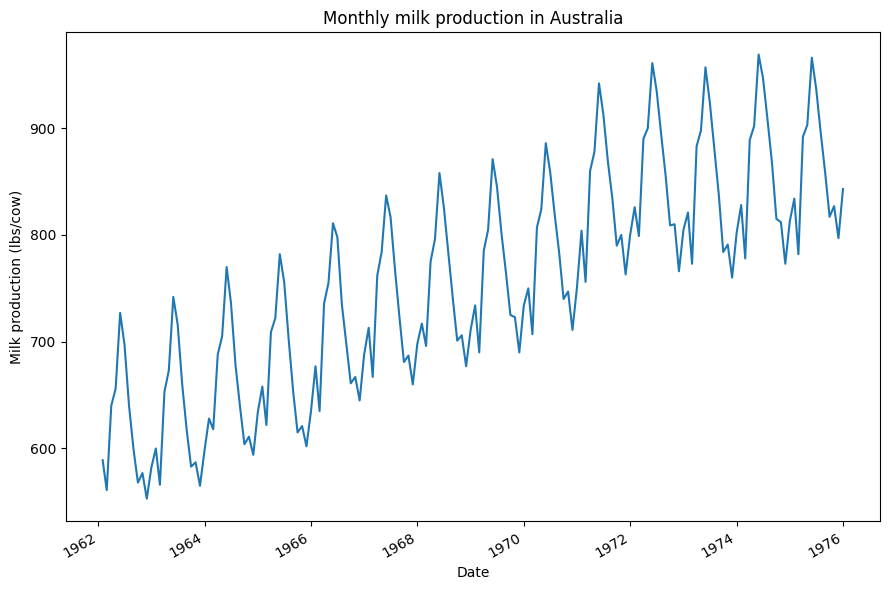

In [89]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

## Decomposition

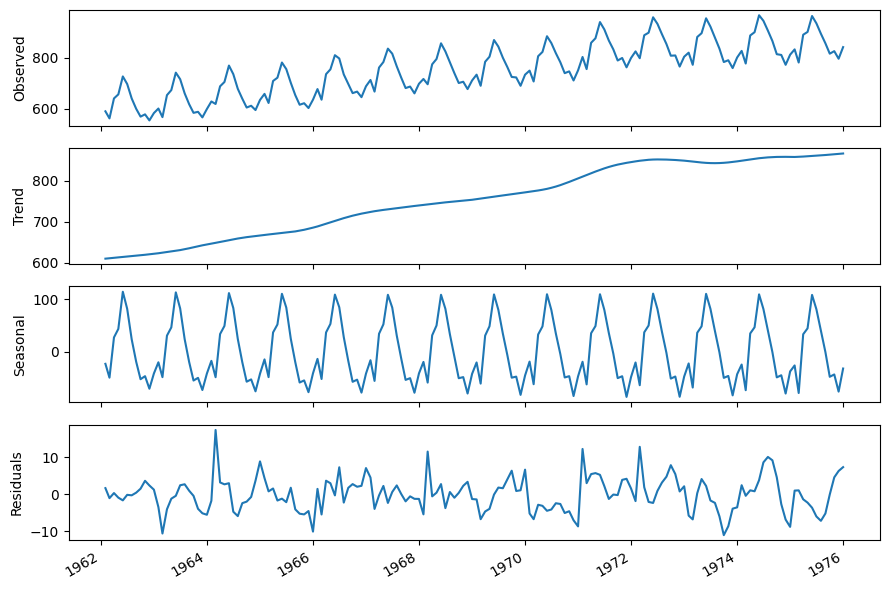

In [90]:
decomposition = STL(df['y'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(df['Date'], decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(df['Date'], decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(df['Date'], decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(df['Date'], decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

# 2. Baseline Models

In [91]:
from statsforecast import StatsForecast
from statsforecast.models import WindowAverage, Naive, SeasonalNaive, HistoricAverage

from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate

### 2.1 Historic average

In [92]:
hist_avg_model = HistoricAverage()

sf = StatsForecast(models=[hist_avg_model], freq='M')
cv_df = sf.cross_validation(h=12, df=df, n_windows=4, step_size=12, refit=True, time_col='Date')

In [93]:
cv_df.head()

,unique_id,Date,cutoff,y,HistoricAverage
0,1,1972-01-31,1971-12-31,826.0,714.808
1,1,1972-02-29,1971-12-31,799.0,714.808
2,1,1972-03-31,1971-12-31,890.0,714.808
3,1,1972-04-30,1971-12-31,900.0,714.808
4,1,1972-05-31,1971-12-31,961.0,714.808


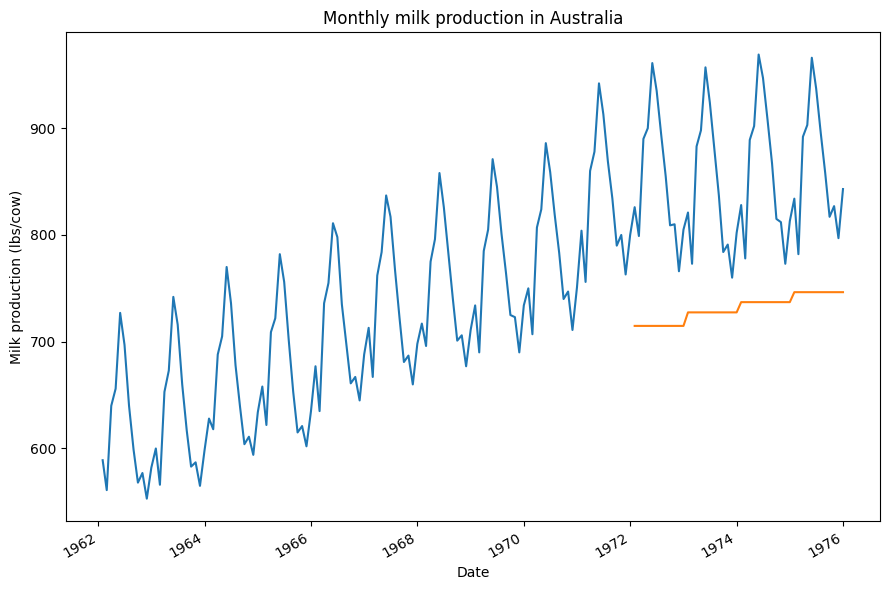

In [94]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.plot(cv_df['Date'], cv_df['HistoricAverage'])
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')

fig.autofmt_xdate()
plt.tight_layout()

### 2.2 Window average

In [95]:
window_avg_model = WindowAverage(window_size=12)

sf = StatsForecast(models=[hist_avg_model, window_avg_model], freq='M')
cv_df = sf.cross_validation(h=12, df=df, n_windows=4, step_size=12, refit=True, time_col='Date')

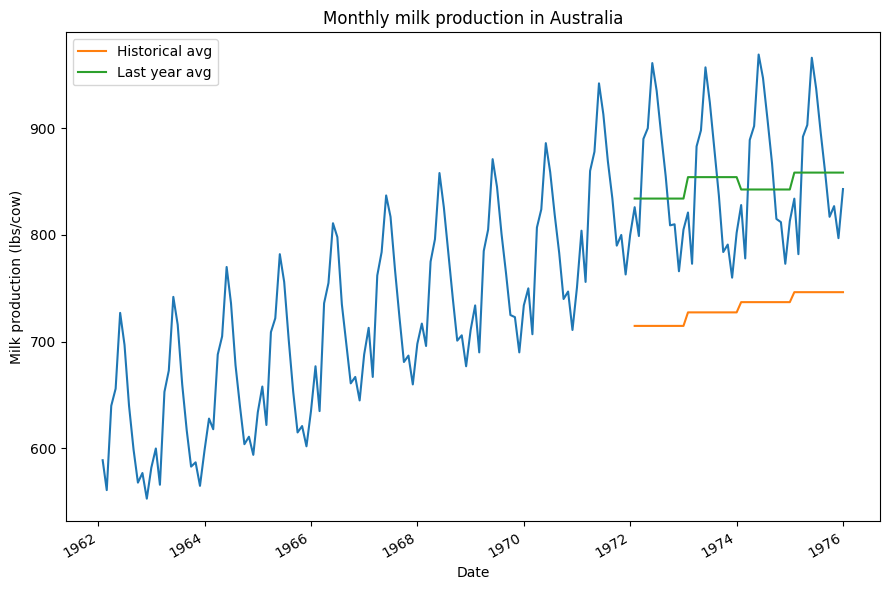

In [96]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.plot(cv_df['Date'], cv_df['HistoricAverage'], label='Historical avg')
ax.plot(cv_df['Date'], cv_df['WindowAverage'], label='Last year avg')
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

### 2.3 Naive

In [97]:
naive_model = Naive()

sf = StatsForecast(models=[hist_avg_model, window_avg_model, naive_model], freq='M')
cv_df = sf.cross_validation(h=12, df=df, n_windows=4, step_size=12, refit=True, time_col='Date')

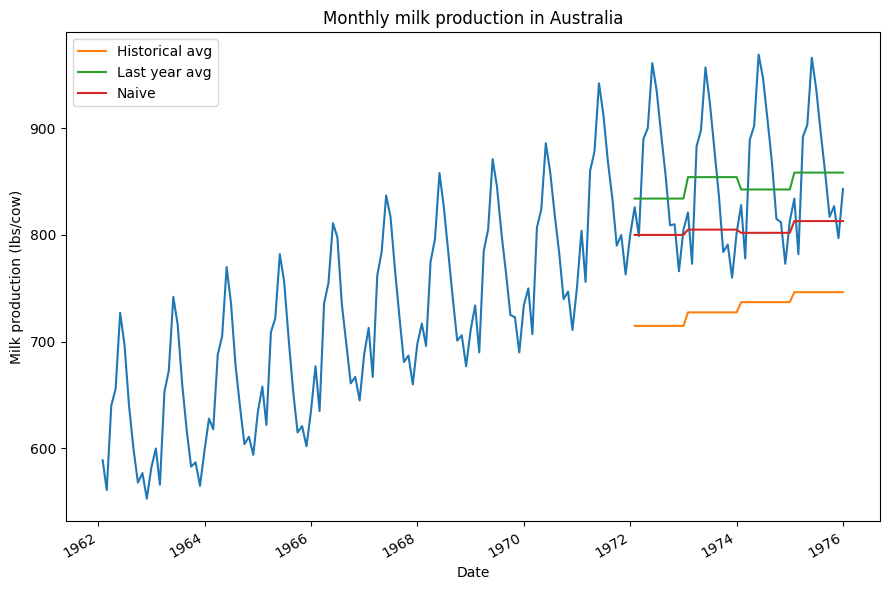

In [98]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.plot(cv_df['Date'], cv_df['HistoricAverage'], label='Historical avg')
ax.plot(cv_df['Date'], cv_df['WindowAverage'], label='Last year avg')
ax.plot(cv_df['Date'], cv_df['Naive'], label='Naive')
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

### 2.4 Seasonal naive

In [99]:
seasonal_naive = SeasonalNaive(season_length=12)

sf = StatsForecast(models=[hist_avg_model, window_avg_model, naive_model, seasonal_naive], freq='M')
cv_df = sf.cross_validation(h=12, df=df, n_windows=4, step_size=12, refit=True, time_col='Date')

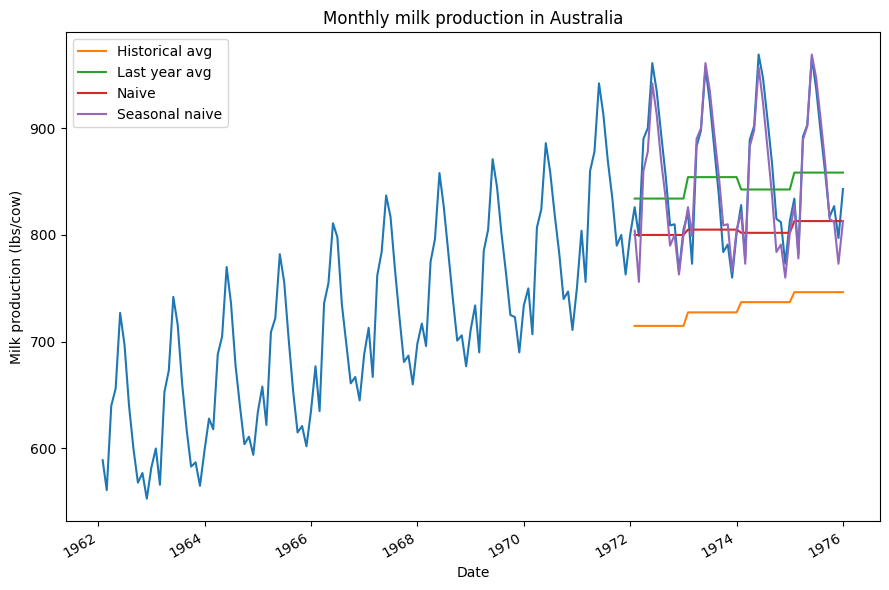

In [100]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['y'])
ax.plot(cv_df['Date'], cv_df['HistoricAverage'], label='Historical avg')
ax.plot(cv_df['Date'], cv_df['WindowAverage'], label='Last year avg')
ax.plot(cv_df['Date'], cv_df['Naive'], label='Naive')
ax.plot(cv_df['Date'], cv_df['SeasonalNaive'], label='Seasonal naive')
ax.set_xlabel('Date')
ax.set_ylabel('Milk production (lbs/cow)')
ax.set_title('Monthly milk production in Australia')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [101]:
### 2.5 Evaluation

In [102]:
cv_df.head()

,unique_id,Date,cutoff,y,HistoricAverage,WindowAverage,Naive,SeasonalNaive
0,1,1972-01-31,1971-12-31,826.0,714.808,834.083,800.0,804.0
1,1,1972-02-29,1971-12-31,799.0,714.808,834.083,800.0,756.0
2,1,1972-03-31,1971-12-31,890.0,714.808,834.083,800.0,860.0
3,1,1972-04-30,1971-12-31,900.0,714.808,834.083,800.0,878.0
4,1,1972-05-31,1971-12-31,961.0,714.808,834.083,800.0,942.0


In [103]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae, mse, rmse, mape, smape])
evaluation

,unique_id,metric,HistoricAverage,WindowAverage,Naive,SeasonalNaive
0,1,mae,123.019,52.483,59.875,14.354
1,1,mse,18731.793,3705.280,6002.750,307.479
2,1,rmse,136.864,60.871,77.477,17.535
3,1,mape,0.140,0.061,0.067,0.017
4,1,smape,0.076,0.031,0.035,0.009


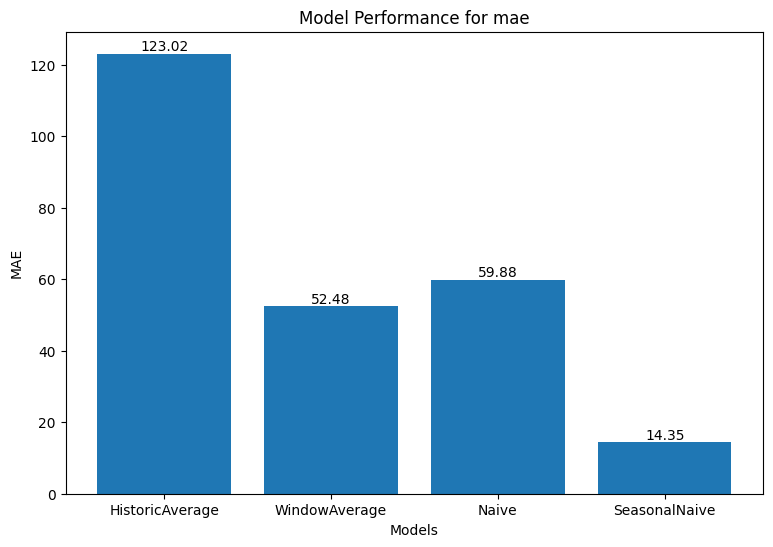

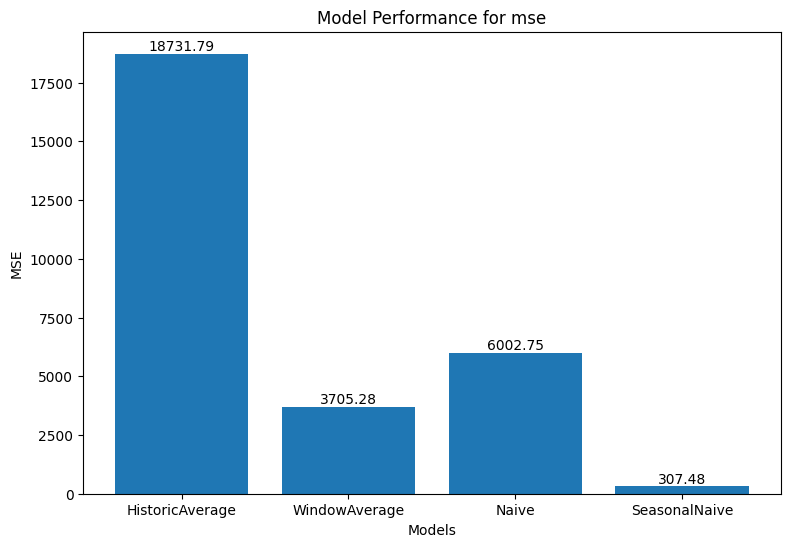

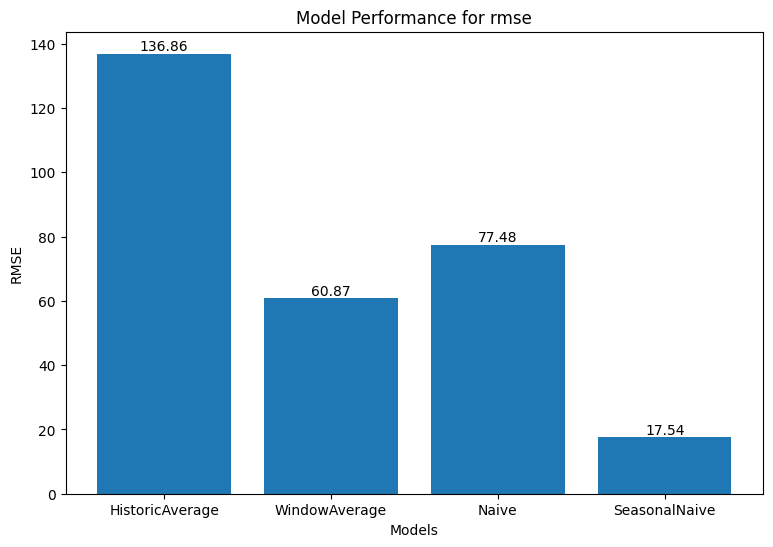

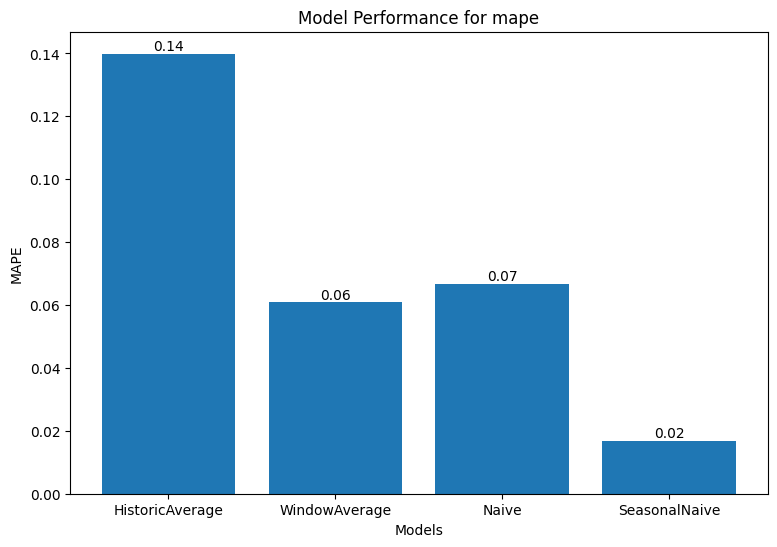

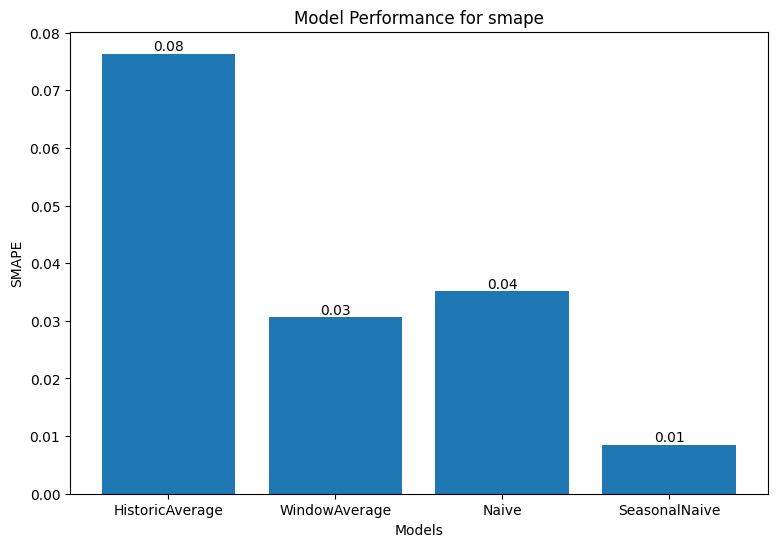

In [104]:
metrics = evaluation['metric']
models = ['HistoricAverage', 'WindowAverage', 'Naive', 'SeasonalNaive']

# Create a plot for each metric
for metric in metrics:
    plt.figure()
    values = evaluation[evaluation['metric'] == metric][models].values[0]
    bars = plt.bar(models, values)
    plt.title(f'Model Performance for {metric}')
    plt.ylabel(metric.upper())
    plt.xlabel('Models')
    
    # Adding value labels on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()


# 3. Random walk

In [105]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

In [106]:
url = "https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesForecastingInPython/refs/heads/master/data/AMZN.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df.insert(0, 'unique_id', 1)

df.head()

,unique_id,Date,Open,High,Low,Close,Adj Close,Volume
0,1,2021-10-05,160.225,163.036,160.123,161.050,161.050,65384000
1,1,2021-10-06,160.676,163.217,159.931,163.100,163.100,50660000
2,1,2021-10-07,164.577,166.288,164.153,165.122,165.122,48182000
3,1,2021-10-08,165.850,166.072,164.410,164.431,164.431,39964000
4,1,2021-10-11,163.750,164.630,161.905,162.315,162.315,40684000


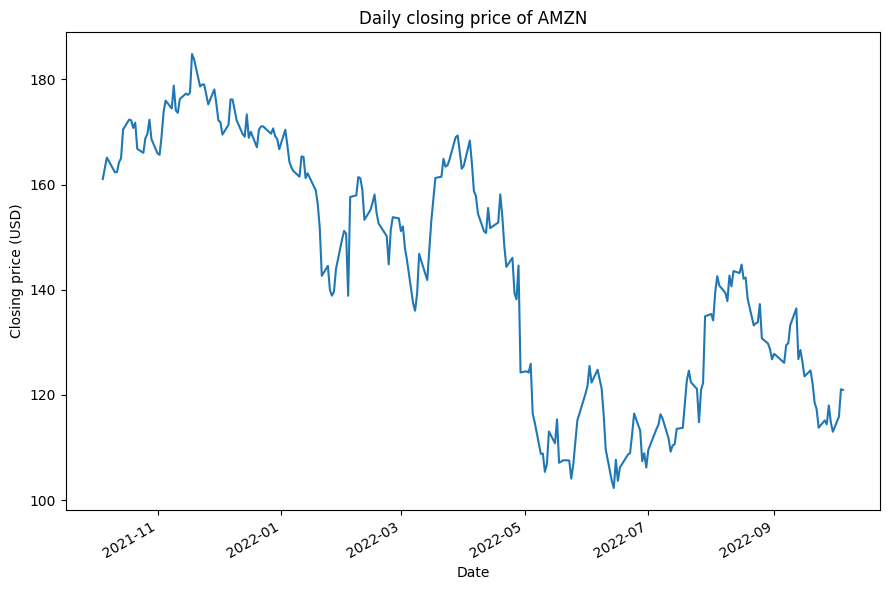

In [107]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of AMZN')

fig.autofmt_xdate()
plt.tight_layout()

In [108]:
AMZN_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {AMZN_ADF_result[0]}')
print(f'p-value: {AMZN_ADF_result[1]}')

ADF Statistic: -1.2571399125314036
p-value: 0.6485457929359857


In [109]:
diff_close = np.diff(df['Close'], n=1)
AMZN_diff_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {AMZN_diff_ADF_result[0]}')
print(f'p-value: {AMZN_diff_ADF_result[1]}')

ADF Statistic: -16.316929753009756
p-value: 3.155381839109975e-29


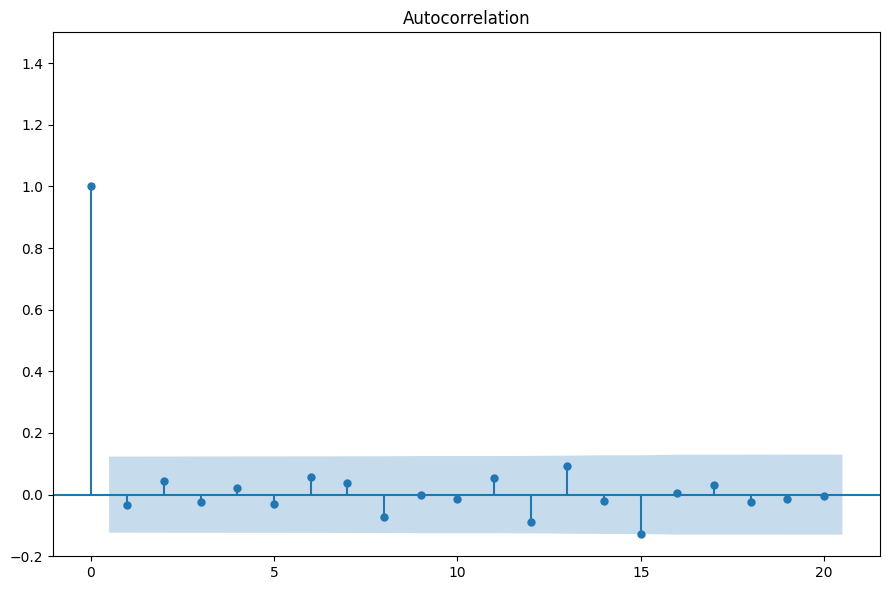

In [110]:
plot_acf(diff_close, lags=20);

plt.ylim(-0.2, 1.5)
plt.tight_layout()

## 3.1 Forecasting a random walk

In [111]:
from statsforecast.models import RandomWalkWithDrift

In [112]:
rwd = RandomWalkWithDrift()

sf = StatsForecast(models=[rwd], freq='B')
cv_df = sf.cross_validation(h=5, df=df, n_windows=10, step_size=5, refit=True, time_col='Date', target_col='Close')

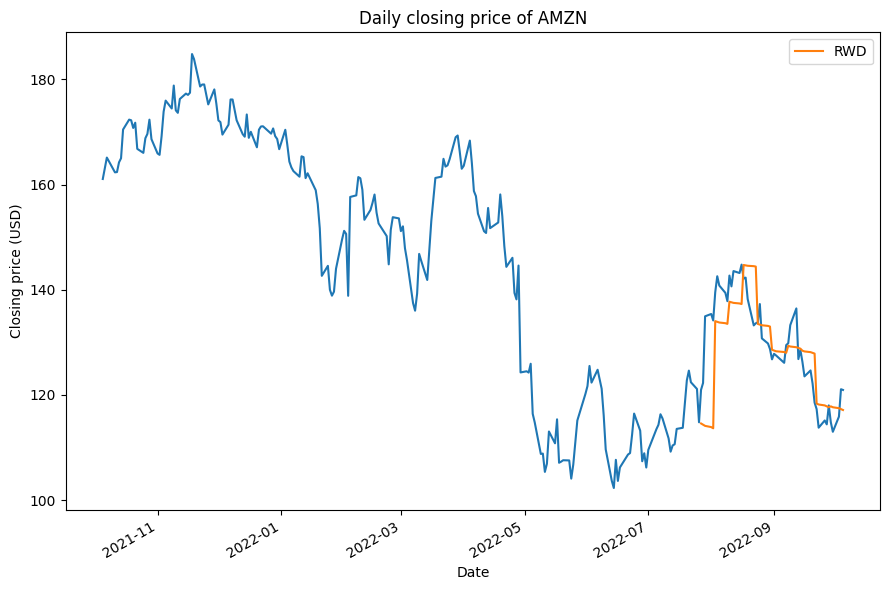

In [113]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.plot(cv_df['Date'], cv_df['RWD'], label='RWD')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of AMZN')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [114]:
naive_model = Naive()
window_avg_model = WindowAverage(window_size=5)

sf = StatsForecast(models=[rwd, naive_model, window_avg_model], freq='B')
cv_df = sf.cross_validation(h=5, df=df, n_windows=10, step_size=5, refit=True, time_col='Date', target_col='Close')

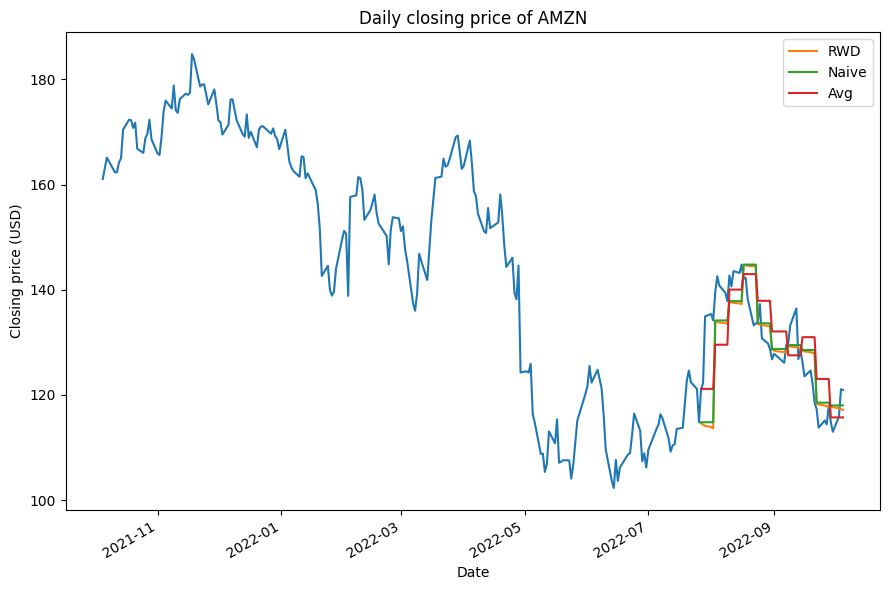

In [115]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.plot(cv_df['Date'], cv_df['RWD'], label='RWD')
ax.plot(cv_df['Date'], cv_df['Naive'], label='Naive')
ax.plot(cv_df['Date'], cv_df['WindowAverage'], label='Avg')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
ax.set_title('Daily closing price of AMZN')
ax.legend(loc='best')

fig.autofmt_xdate()
plt.tight_layout()

In [116]:
cv_df.head()

,unique_id,Date,cutoff,Close,RWD,Naive,WindowAverage
0,1,2022-07-27,2022-07-26,120.97,114.581,114.81,121.154
1,1,2022-07-28,2022-07-26,122.28,114.352,114.81,121.154
2,1,2022-07-29,2022-07-26,134.95,114.123,114.81,121.154
3,1,2022-08-01,2022-07-26,135.39,113.894,114.81,121.154
4,1,2022-08-02,2022-07-26,134.16,113.665,114.81,121.154


In [117]:
eval_df = cv_df.drop(['Date', 'cutoff'], axis=1)
evaluation = evaluate(df=eval_df, metrics=[mae], target_col='Close')
evaluation

,unique_id,metric,RWD,Naive,WindowAverage
0,1,mae,5.178,5.174,5.918


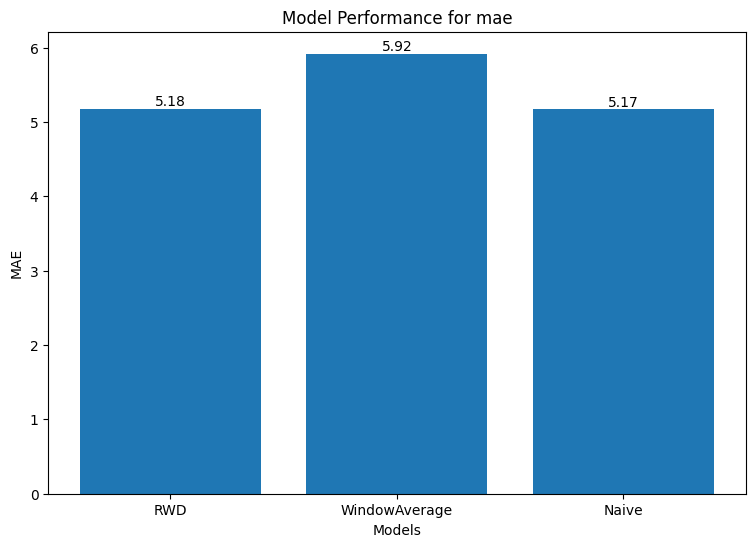

In [119]:
metrics = evaluation['metric']
models = ['RWD', 'WindowAverage', 'Naive']

# Create a plot for each metric
for metric in metrics:
    plt.figure()
    values = evaluation[evaluation['metric'] == metric][models].values[0]
    bars = plt.bar(models, values)
    plt.title(f'Model Performance for {metric}')
    plt.ylabel(metric.upper())
    plt.xlabel('Models')
    
    # Adding value labels on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()